In [1]:
# =========================================================
# PHASE 1: IMPORTS & DATASET LOADER
# =========================================================

# ------------------------------
# 🔹 Imports
# ------------------------------
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta

# ------------------------------
# 🔹 Dataset Loader with Caching
# ------------------------------
_last_loaded_path = None
_last_loaded_df = None

def load_dataset(path, force_reload=False):
    """
    Loads a CSV dataset efficiently with caching.
    - path: file path to CSV
    - force_reload: reload even if cached
    Returns a copy of the dataframe.
    """
    global _last_loaded_path, _last_loaded_df
    if force_reload or _last_loaded_df is None or path != _last_loaded_path:
        if not os.path.exists(path):
            raise FileNotFoundError(f"Dataset not found at: {path}")
        _last_loaded_df = pd.read_csv(path)
        _last_loaded_path = path
        print(f"✅ Dataset loaded from: {path}")
    else:
        print(f"ℹ️ Using cached dataset for: {path}")
    return _last_loaded_df.copy()

# ------------------------------
# 🔹 Initial Dataset Path
# ------------------------------
DATASET_PATH = r"C:\Users\alanm\OneDrive\Documents\internshi[ project\dataset\employee_data.csv"

# Load dataset (first load)
df = load_dataset(DATASET_PATH)
print("🔹 Dataset shape:", df.shape)
print("🔹 Columns:")
print(df.columns.tolist())

# Preview first 5 rows
print("\n🔹 Sample data:")
print(df.head())


✅ Dataset loaded from: C:\Users\alanm\OneDrive\Documents\internshi[ project\dataset\employee_data.csv
🔹 Dataset shape: (3000, 26)
🔹 Columns:
['EmpID', 'FirstName', 'LastName', 'StartDate', 'ExitDate', 'Title', 'Supervisor', 'ADEmail', 'BusinessUnit', 'EmployeeStatus', 'EmployeeType', 'PayZone', 'EmployeeClassificationType', 'TerminationType', 'TerminationDescription', 'DepartmentType', 'Division', 'DOB', 'State', 'JobFunctionDescription', 'GenderCode', 'LocationCode', 'RaceDesc', 'MaritalDesc', 'Performance Score', 'Current Employee Rating']

🔹 Sample data:
   EmpID FirstName LastName  StartDate ExitDate                    Title  \
0   3427     Uriah  Bridges  20-Sep-19      NaN  Production Technician I   
1   3428     Paula    Small  11-Feb-23      NaN  Production Technician I   
2   3429    Edward     Buck  10-Dec-18      NaN       Area Sales Manager   
3   3430   Michael  Riordan  21-Jun-21      NaN       Area Sales Manager   
4   3431   Jasmine    Onque  29-Jun-19      NaN       Ar

In [2]:
# =========================================================
# PHASE 2: INITIAL DATASET CHECKS & PII REMOVAL
# =========================================================

# ------------------------------
# 🔹 Basic Dataset Overview
# ------------------------------
print("\n🔹 Dataset Info:")
df.info()

print("\n🔹 Missing Values Summary:")
missing_summary = df.isnull().sum().sort_values(ascending=False)
print(missing_summary[missing_summary > 0])

print("\n🔹 Sample rows with missing values:")
print(df[df.isnull().any(axis=1)].head(10))

# ------------------------------
# 🔹 Drop PII Columns
# ------------------------------
pii_columns = ['FirstName', 'LastName', 'ADEmail']
for col in pii_columns:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)
        print(f"✅ Dropped PII column: {col}")

# ------------------------------
# 🔹 Check Updated Dataset
# ------------------------------
print("\n🔹 Updated Columns:")
print(df.columns.tolist())

print("\n🔹 Dataset shape after PII removal:", df.shape)

# ------------------------------
# 🔹 Save intermediate cleaned dataset (optional)
# ------------------------------
output_folder = r"C:\Users\alanm\OneDrive\Documents\internshi[ project\cleaned intermediate"
os.makedirs(output_folder, exist_ok=True)
intermediate_path = os.path.join(output_folder, "phase2_pii_removed.csv")
df.to_csv(intermediate_path, index=False)
print(f"✅ Phase 2 dataset saved at: {intermediate_path}")



🔹 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   EmpID                       3000 non-null   int64 
 1   FirstName                   3000 non-null   object
 2   LastName                    3000 non-null   object
 3   StartDate                   3000 non-null   object
 4   ExitDate                    1533 non-null   object
 5   Title                       3000 non-null   object
 6   Supervisor                  3000 non-null   object
 7   ADEmail                     3000 non-null   object
 8   BusinessUnit                3000 non-null   object
 9   EmployeeStatus              3000 non-null   object
 10  EmployeeType                3000 non-null   object
 11  PayZone                     3000 non-null   object
 12  EmployeeClassificationType  3000 non-null   object
 13  TerminationType             300

In [3]:
# =========================================================
# PHASE 3: DATE CONVERSION & DERIVED COLUMNS
# =========================================================

# ------------------------------
# 🔹 Convert Date Columns
# ------------------------------
date_columns = ['StartDate', 'ExitDate', 'DOB']
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        print(f"✅ Converted {col} to datetime")

# ------------------------------
# 🔹 Handle missing ExitDate
# ------------------------------
df['IsActive'] = df['ExitDate'].isna()
print("\n🔹 Sample IsActive column:")
print(df[['EmpID', 'StartDate', 'ExitDate', 'IsActive']].head(5))

# ------------------------------
# 🔹 Compute TenureDays
# ------------------------------
today = pd.Timestamp.today()
df['TenureDays'] = (df['ExitDate'].fillna(today) - df['StartDate']).dt.days
print("\n🔹 Sample TenureDays column:")
print(df[['EmpID', 'StartDate', 'ExitDate', 'TenureDays']].head(5))

# ------------------------------
# 🔹 Compute Age
# ------------------------------
df['Age'] = ((today - df['DOB']).dt.days / 365.25).round(1)
print("\n🔹 Sample Age column:")
print(df[['EmpID', 'DOB', 'Age']].head(5))

# ------------------------------
# 🔹 Create AgeGroup bins
# ------------------------------
age_bins = [0, 29, 39, 49, 59, 69, 120]
age_labels = ['<30', '30s', '40s', '50s', '60s', '70+']
df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels)
print("\n🔹 Sample AgeGroup column:")
print(df[['EmpID', 'Age', 'AgeGroup']].head(10))

# ------------------------------
# 🔹 Save intermediate dataset for Phase 3
# ------------------------------
intermediate_path_phase3 = os.path.join(output_folder, "phase3_dates_derived.csv")
df.to_csv(intermediate_path_phase3, index=False)
print(f"✅ Phase 3 dataset saved at: {intermediate_path_phase3}")


✅ Converted StartDate to datetime
✅ Converted ExitDate to datetime
✅ Converted DOB to datetime

🔹 Sample IsActive column:
   EmpID  StartDate ExitDate  IsActive
0   3427 2019-09-20      NaT      True
1   3428 2023-02-11      NaT      True
2   3429 2018-12-10      NaT      True
3   3430 2021-06-21      NaT      True
4   3431 2019-06-29      NaT      True

🔹 Sample TenureDays column:
   EmpID  StartDate ExitDate  TenureDays
0   3427 2019-09-20      NaT        2280
1   3428 2023-02-11      NaT        1040
2   3429 2018-12-10      NaT        2564
3   3430 2021-06-21      NaT        1640
4   3431 2019-06-29      NaT        2363

🔹 Sample Age column:
   EmpID        DOB   Age
0   3427 1969-07-10  56.4
1   3428        NaT   NaN
2   3429 1991-06-10  34.5
3   3430 1998-04-04  27.7
4   3431        NaT   NaN

🔹 Sample AgeGroup column:
   EmpID   Age AgeGroup
0   3427  56.4      50s
1   3428   NaN      NaN
2   3429  34.5      30s
3   3430  27.7      <30
4   3431   NaN      NaN
5   3432  76.8      

C:\Users\alanm\AppData\Local\Temp\ipykernel_19644\2191212682.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
C:\Users\alanm\AppData\Local\Temp\ipykernel_19644\2191212682.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


In [4]:
# =========================================================
# PHASE 4: FEATURE MAPPING
# =========================================================

# ------------------------------
# 🔹 4.1 Title → JobFamily & SeniorityLevel
# ------------------------------
df['Title'] = df['Title'].str.strip()

def map_job_family(title):
    title = str(title).lower()
    if any(x in title for x in ['data', 'bi', 'dba', 'analyst']):
        return 'Data & Analytics'
    elif any(x in title for x in ['it', 'network', 'infra', 'support']):
        return 'IT & Infrastructure'
    elif 'sales' in title:
        return 'Sales'
    elif 'accountant' in title:
        return 'Finance & Accounting'
    elif any(x in title for x in ['president', 'ceo', 'cio', 'director']):
        return 'Executive & Leadership'
    elif 'manager' in title and 'production' not in title:
        return 'Operations / Shared Services'
    elif 'production' in title:
        return 'Production'
    elif 'admin' in title:
        return 'Admin & Support'
    else:
        return 'Other'

def map_seniority_level(title):
    title = str(title).lower()
    if any(x in title for x in ['president', 'ceo', 'cio']):
        return 'Executive'
    elif 'director' in title:
        return 'Director'
    elif 'manager' in title:
        return 'Manager'
    elif any(x in title for x in ['sr', 'senior', 'principal']):
        return 'Senior'
    elif 'ii' in title:
        return 'Mid'
    elif 'i' in title:
        return 'Entry'
    else:
        return 'Mid'

df['JobFamily'] = df['Title'].apply(map_job_family)
df['SeniorityLevel'] = df['Title'].apply(map_seniority_level)

print("\n🔹 Sample JobFamily & SeniorityLevel:")
print(df[['Title', 'JobFamily', 'SeniorityLevel']].head(10))

# ------------------------------
# 🔹 4.2 Division → DivisionGroup
# ------------------------------
df['Division'] = df['Division'].fillna('Unknown')

def map_division_group(division):
    division = str(division).lower().strip()
    if 'finance' in division:
        return 'Finance'
    elif 'technology' in division or 'it' in division:
        return 'IT'
    elif any(x in division for x in ['sales', 'marketing']):
        return 'Sales & Marketing'
    elif 'executive' in division:
        return 'Executive'
    elif 'people' in division:
        return 'HR / People Services'
    elif 'project management' in division:
        return 'Project Management'
    elif division.startswith('general'):
        return 'General Operations'
    elif any(x in division for x in ['aerial', 'splicing', 'field', 'wireline', 'catv', 'isp']):
        return 'Field Engineering / Operations'
    elif 'consultant' in division:
        return 'Consulting / Client Delivery'
    elif any(x in division for x in ['yard', 'fleet', 'shop']):
        return 'Logistics / Maintenance'
    elif 'safety' in division:
        return 'Safety & Compliance'
    elif 'corp' in division:
        return 'Corporate Operations'
    elif division == 'unknown':
        return 'Unknown'
    else:
        return 'Other'

df['DivisionGroup'] = df['Division'].apply(map_division_group)

# ------------------------------
# 🔹 4.3 JobFunctionDescription → JobFunctionGroup
# ------------------------------
df['JobFunctionDescription'] = df['JobFunctionDescription'].fillna('Unknown')

mapping_keywords = {
    'Engineering': ['engineer', 'drafter', 'planner'],
    'Field Operations': ['technician', 'lineman', 'field'],
    'Labor & Site Work': ['labor', 'helper', 'flagger'],
    'Project / Site Management': ['manager', 'supervisor', 'foreman'],
    'Executive & Leadership': ['vp', 'ceo', 'cfo', 'director'],
    'Finance & Analysis': ['analyst', 'accountant', 'billing'],
    'Admin & Support': ['admin', 'assistant', 'clerk'],
    'Health & Safety': ['safety'],
    'Maintenance & Logistics': ['mechanic', 'warehouse'],
    'HR / Talent': ['recruit', 'hr'],
    'Internship': ['intern'],
    'Unknown': ['unknown']
}

def map_job_function(role):
    role = str(role).lower().strip()
    for group, keywords in mapping_keywords.items():
        if any(k in role for k in keywords):
            return group
    return 'Other'

df['JobFunctionGroup'] = df['JobFunctionDescription'].apply(map_job_function)

# ------------------------------
# 🔹 4.4 State → Region
# ------------------------------
df['State'] = df['State'].fillna('Unknown')

region_mapping = {
    'West': ['CA', 'OR', 'WA', 'NV', 'AZ', 'UT', 'ID', 'MT'],
    'Midwest': ['ND', 'IN', 'OH'],
    'South': ['TX', 'FL', 'GA', 'AL', 'KY', 'TN', 'NC', 'VA'],
    'Northeast': ['MA', 'CT', 'RI', 'VT', 'NY', 'PA', 'NH', 'ME'],
    'Unknown': ['Unknown']
}

def map_region(state):
    state = str(state).upper()
    for region, states in region_mapping.items():
        if state in states:
            return region
    return 'Other'

df['Region'] = df['State'].apply(map_region)

# ------------------------------
# 🔹 Save intermediate dataset for Phase 4
# ------------------------------
intermediate_path_phase4 = os.path.join(output_folder, "phase4_feature_mapped.csv")
df.to_csv(intermediate_path_phase4, index=False)
print(f"✅ Phase 4 dataset saved at: {intermediate_path_phase4}")



🔹 Sample JobFamily & SeniorityLevel:
                     Title   JobFamily SeniorityLevel
0  Production Technician I  Production          Entry
1  Production Technician I  Production          Entry
2       Area Sales Manager       Sales        Manager
3       Area Sales Manager       Sales        Manager
4       Area Sales Manager       Sales        Manager
5       Area Sales Manager       Sales        Manager
6       Area Sales Manager       Sales        Manager
7       Area Sales Manager       Sales        Manager
8       Area Sales Manager       Sales        Manager
9       Area Sales Manager       Sales        Manager
✅ Phase 4 dataset saved at: C:\Users\alanm\OneDrive\Documents\internshi[ project\cleaned intermediate\phase4_feature_mapped.csv


In [5]:
# =========================================================
# PHASE 5: MISSING VALUE ANALYSIS FOR AGE & DOB
# =========================================================

# ------------------------------
# 🔹 Identify rows with missing Age or DOB
# ------------------------------
missing_dob_age = df[df['DOB'].isna() | df['Age'].isna()]

print("\n🔍 Number of missing values:")
print("DOB missing:", df['DOB'].isna().sum())
print("Age missing:", df['Age'].isna().sum())

print("\n📋 Sample rows with missing DOB or Age:")
print(missing_dob_age[['EmpID', 'DOB', 'Age', 'SeniorityLevel', 'JobFamily']].head(10))

# ------------------------------
# 🔹 Missing summary by SeniorityLevel & JobFamily
# ------------------------------
missing_df = df[df['DOB'].isna() | df['Age'].isna()]
missing_summary = missing_df.groupby(['SeniorityLevel', 'JobFamily']).size().reset_index(name='MissingCount')
missing_summary = missing_summary.sort_values(by='MissingCount', ascending=False)

print("\n🔍 Missing DOB/Age grouped by SeniorityLevel & JobFamily:")
print(missing_summary)

# ------------------------------
# 🔹 Calculate Missing Percent per group
# ------------------------------
total_per_group = df.groupby(['SeniorityLevel', 'JobFamily']).size().reset_index(name='TotalCount')
merged = pd.merge(missing_summary, total_per_group, on=['SeniorityLevel', 'JobFamily'])
merged['MissingPercent'] = (merged['MissingCount'] / merged['TotalCount'] * 100).round(1)

print("\n📊 Missing Percent per group (top 10):")
print(merged.sort_values(by='MissingPercent', ascending=False).head(10))

# ------------------------------
# 🔹 Save missing value report
# ------------------------------
missing_report_path = os.path.join(output_folder, "phase5_missing_summary.csv")
merged.to_csv(missing_report_path, index=False)
print(f"✅ Missing value summary saved at: {missing_report_path}")



🔍 Number of missing values:
DOB missing: 1823
Age missing: 1823

📋 Sample rows with missing DOB or Age:
    EmpID DOB  Age SeniorityLevel   JobFamily
1    3428 NaT  NaN          Entry  Production
4    3431 NaT  NaN        Manager       Sales
8    3435 NaT  NaN        Manager       Sales
10   3437 NaT  NaN        Manager       Sales
12   3439 NaT  NaN        Manager       Sales
14   3441 NaT  NaN        Manager       Sales
15   3442 NaT  NaN        Manager       Sales
17   3444 NaT  NaN        Manager       Sales
20   3447 NaT  NaN        Manager       Sales
22   3449 NaT  NaN        Manager       Sales

🔍 Missing DOB/Age grouped by SeniorityLevel & JobFamily:
   SeniorityLevel                     JobFamily  MissingCount
9           Entry                    Production           796
16            Mid                    Production           310
14        Manager                         Sales           195
13        Manager                    Production            99
7           Entry    

In [6]:
# =========================================================
# PHASE 6: IMPUTATION OF AGE & DOB
# =========================================================

# ------------------------------
# 🔹 Step 1: Replace Age=0 with NaN
# ------------------------------
df['Age'] = df['Age'].replace(0, np.nan)

# ------------------------------
# 🔹 Step 2: Fill Age by median of SeniorityLevel
# ------------------------------
df['Age'] = df.groupby('SeniorityLevel')['Age'].transform(lambda x: x.fillna(x.median()))

# ------------------------------
# 🔹 Step 3: Recompute DOB from Age if missing
# ------------------------------
today = pd.Timestamp.today()
df['DOB'] = df['DOB'].fillna(today - pd.to_timedelta(df['Age'] * 365.25, unit='D'))

# ------------------------------
# 🔹 Step 4: AgeGroup Analysis & Fill Missing AgeGroup
# ------------------------------
age_bins = [0, 29, 39, 49, 59, 69, 120]
age_labels = ['<30', '30s', '40s', '50s', '60s', '70+']
df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels)

# Predict missing AgeGroup using mode by SeniorityLevel + JobFamily
agegroup_map = (
    df[df['AgeGroup'].notna()]
    .groupby(['SeniorityLevel', 'JobFamily'])['AgeGroup']
    .agg(lambda x: x.mode().iloc[0])
    .reset_index()
    .rename(columns={'AgeGroup': 'PredictedAgeGroup'})
)

df = df.merge(agegroup_map, on=['SeniorityLevel', 'JobFamily'], how='left')
df['FinalAgeGroup'] = df['AgeGroup']
df.loc[df['FinalAgeGroup'].isna(), 'FinalAgeGroup'] = df.loc[df['FinalAgeGroup'].isna(), 'PredictedAgeGroup']

print("\n✅ Final AgeGroup Filling Summary:")
print(df['FinalAgeGroup'].value_counts(dropna=False))

# Save predicted AgeGroup for missing Age
missing_predicted = df[df['Age'].isna()][['EmpID', 'SeniorityLevel', 'JobFamily', 'PredictedAgeGroup']]
predicted_agegroup_path = os.path.join(output_folder, "phase6_predicted_missing_agegroup.csv")
missing_predicted.to_csv(predicted_agegroup_path, index=False)
print(f"✅ Predicted AgeGroups for missing Age saved at: {predicted_agegroup_path}")

# ------------------------------
# 🔹 Step 5: Impute Age from AgeGroup
# ------------------------------
agegroup_to_age = {'<30': 25, '30s': 35, '40s': 45, '50s': 55, '60s': 65, '70+': 75}
df['ImputedAge'] = df['FinalAgeGroup'].map(agegroup_to_age)
df['Age'] = df['Age'].fillna(df['ImputedAge'])

# ------------------------------
# 🔹 Step 6: Recompute DOB from Age if still missing
# ------------------------------
def calculate_dob(age):
    if pd.isna(age):
        return pd.NaT
    else:
        return today - relativedelta(years=int(age))

df['DOB'] = df['DOB'].fillna(df['Age'].apply(calculate_dob))
df.drop(columns=['ImputedAge'], inplace=True)

print("\n✅ Missing values after imputation:")
print("DOB missing:", df['DOB'].isna().sum())
print("Age missing:", df['Age'].isna().sum())

# ------------------------------
# 🔹 Save intermediate dataset for Phase 6
# ------------------------------
intermediate_path_phase6 = os.path.join(output_folder, "phase6_age_dob_imputed.csv")
df.to_csv(intermediate_path_phase6, index=False)
print(f"✅ Phase 6 dataset saved at: {intermediate_path_phase6}")



✅ Final AgeGroup Filling Summary:
FinalAgeGroup
50s    1877
60s     330
70+     297
30s     221
40s     189
<30      86
Name: count, dtype: int64
✅ Predicted AgeGroups for missing Age saved at: C:\Users\alanm\OneDrive\Documents\internshi[ project\cleaned intermediate\phase6_predicted_missing_agegroup.csv

✅ Missing values after imputation:
DOB missing: 0
Age missing: 0
✅ Phase 6 dataset saved at: C:\Users\alanm\OneDrive\Documents\internshi[ project\cleaned intermediate\phase6_age_dob_imputed.csv



📅 Most likely dataset year (mode): 2025
📊 Average estimated dataset year (mean): 2025.0


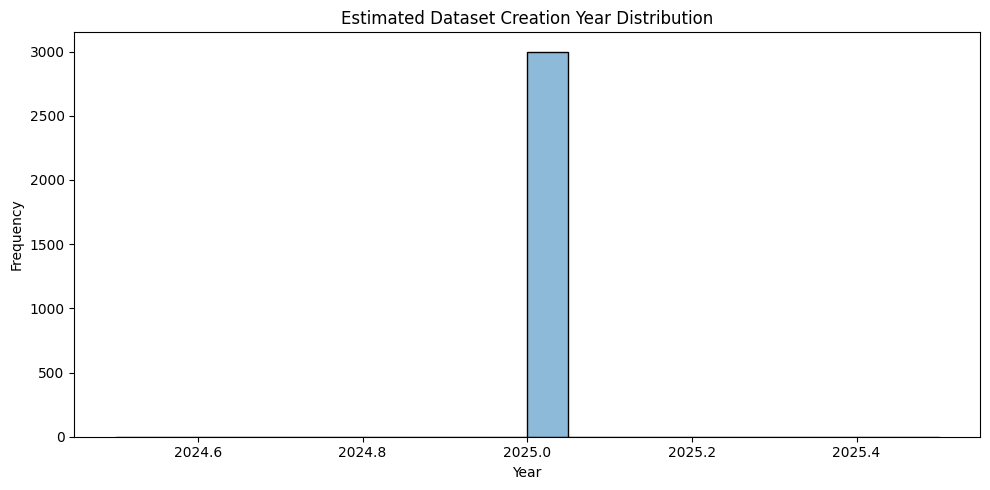

✅ Phase 7 dataset saved at: C:\Users\alanm\OneDrive\Documents\internshi[ project\cleaned intermediate\phase7_birthyear_estimation.csv


In [7]:
# =========================================================
# PHASE 7: BIRTHYEAR & DATASET YEAR ESTIMATION
# =========================================================

# ------------------------------
# 🔹 Step 1: Compute BirthYear & JoinYear
# ------------------------------
df['BirthYear'] = df['DOB'].dt.year
df['StartDate'] = pd.to_datetime(df['StartDate'], errors='coerce')
df['JoinYear'] = df['StartDate'].dt.year

# ------------------------------
# 🔹 Step 2: Estimate missing BirthYear from JoinYear - 25
# ------------------------------
df['EstimatedBirthYear'] = df['JoinYear'] - 25
df['BirthYear'] = df['BirthYear'].fillna(df['EstimatedBirthYear'])

# ------------------------------
# 🔹 Step 3: Fill missing BirthYear using group median
# ------------------------------
group_birthyear = df[~df['BirthYear'].isna()].groupby(['SeniorityLevel', 'JobFamily'])['BirthYear'].median().reset_index()
df = df.merge(group_birthyear, on=['SeniorityLevel', 'JobFamily'], how='left', suffixes=('', '_GroupMedian'))
df['BirthYear'] = df['BirthYear'].fillna(df['BirthYear_GroupMedian'])

# ------------------------------
# 🔹 Step 4: Recompute Age based on final BirthYear
# ------------------------------
current_year = pd.Timestamp.today().year
df['Age'] = current_year - df['BirthYear']
df['DOB'] = pd.to_datetime(df['DOB'], errors='coerce')  # ensure consistency

# ------------------------------
# 🔹 Step 5: Estimate dataset creation year
# ------------------------------
valid_rows = df[df['DOB'].notna() & df['Age'].notna()]
valid_rows['EstimatedDatasetYear'] = valid_rows['DOB'].dt.year + valid_rows['Age'].astype(int)

estimated_year_mode = valid_rows['EstimatedDatasetYear'].mode().iloc[0]
estimated_year_mean = round(valid_rows['EstimatedDatasetYear'].mean(), 1)

print(f"\n📅 Most likely dataset year (mode): {estimated_year_mode}")
print(f"📊 Average estimated dataset year (mean): {estimated_year_mean}")

# Plot distribution
plt.figure(figsize=(10, 5))
sns.histplot(valid_rows['EstimatedDatasetYear'], bins=20, kde=True)
plt.title("Estimated Dataset Creation Year Distribution")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# ------------------------------
# 🔹 Save intermediate dataset for Phase 7
# ------------------------------
intermediate_path_phase7 = os.path.join(output_folder, "phase7_birthyear_estimation.csv")
df.to_csv(intermediate_path_phase7, index=False)
print(f"✅ Phase 7 dataset saved at: {intermediate_path_phase7}")



🔹 Correlation of features with Age:
Age                           1.000000
SeniorityLevel                0.094980
Title                         0.031498
EmpID                         0.030502
JobFunctionDescription        0.023835
Division                      0.023392
Supervisor                    0.020003
DivisionGroup                 0.013702
GenderCode                    0.013552
EmployeeClassificationType    0.008771
Performance Score             0.007505
TenureDays                    0.007292
IsActive                      0.007106
LocationCode                  0.006626
TerminationDescription        0.002326
EmployeeStatus               -0.000455
TerminationType              -0.001405
EmployeeType                 -0.002848
RaceDesc                     -0.003420
MaritalDesc                  -0.004721
BusinessUnit                 -0.006492
JobFunctionGroup             -0.008509
JoinYear                     -0.009346
EstimatedBirthYear           -0.009346
Current Employee Rating    

C:\Users\alanm\AppData\Local\Temp\ipykernel_19644\2451617495.py:52: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(known_age, label="Original Ages", shade=True, linewidth=2)
C:\Users\alanm\AppData\Local\Temp\ipykernel_19644\2451617495.py:53: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(imputed_age, label="Imputed Ages", shade=True, linewidth=2, linestyle="--")


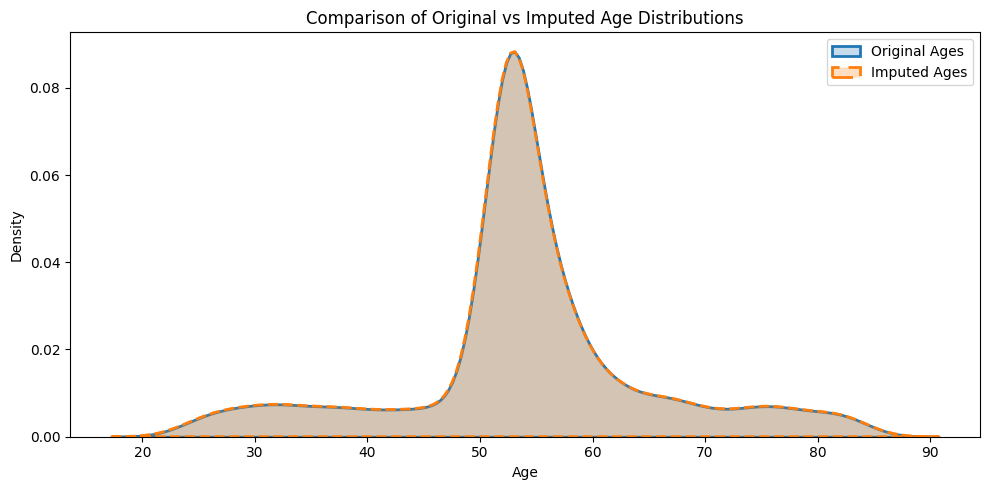

C:\Users\alanm\AppData\Local\Temp\ipykernel_19644\2451617495.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\alanm\AppData\Local\Temp\ipykernel_19644\2451617495.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\alanm\AppData\Local\Temp\ipykernel_19644\2451617495.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\alanm\AppData\Local\Temp\ipykernel_19644\2451617495.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `h

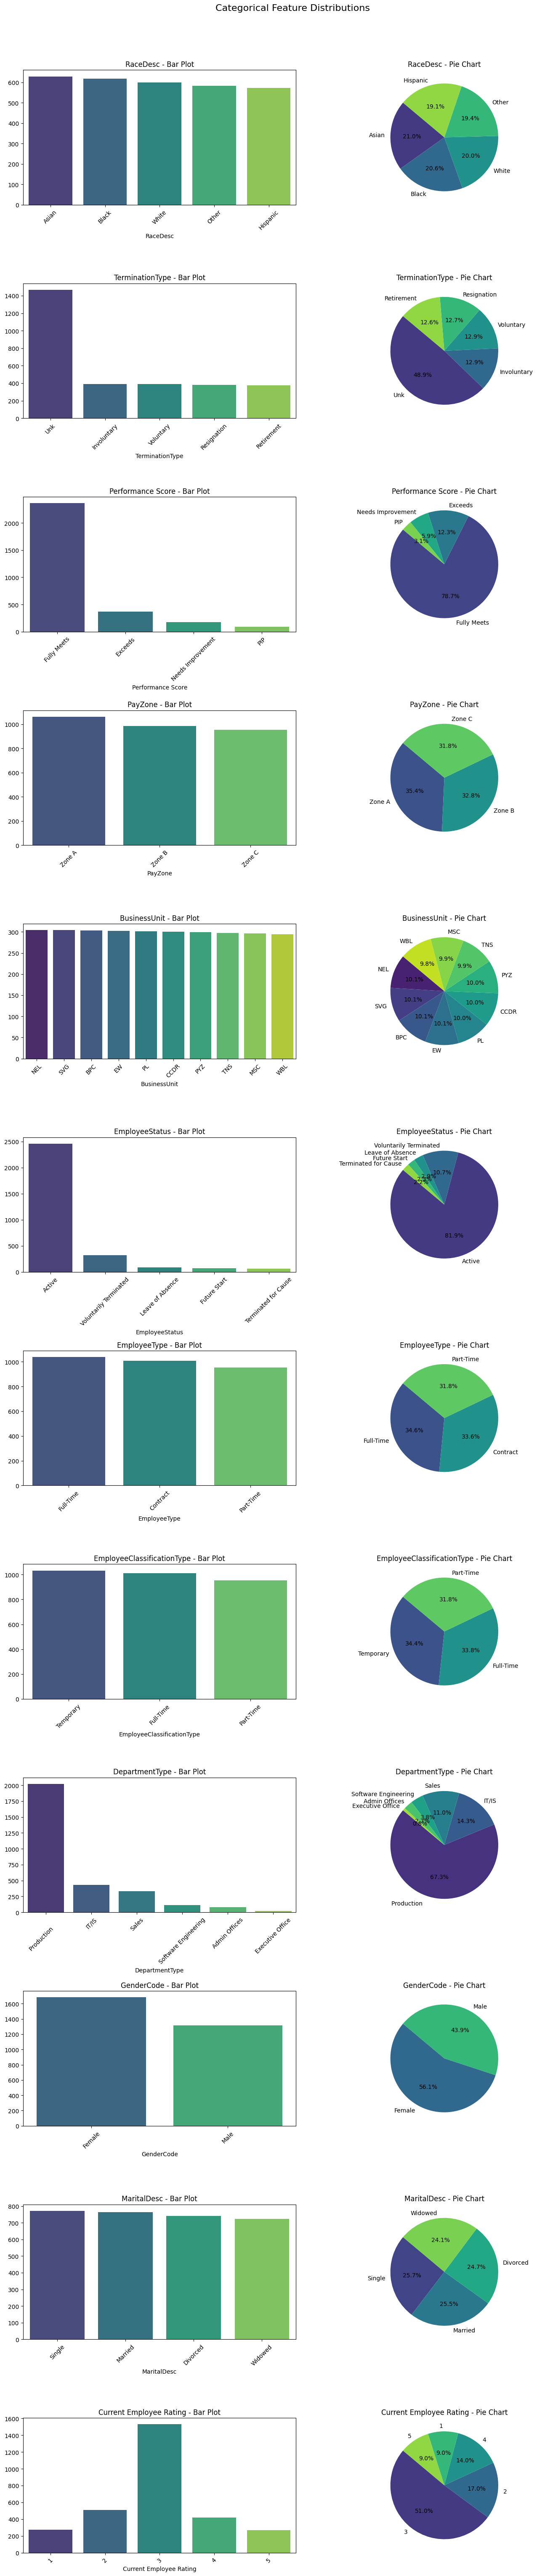

✅ Phase 8 dataset saved at: C:\Users\alanm\OneDrive\Documents\internshi[ project\cleaned intermediate\phase8_eda_visualizations.csv


In [8]:
# =========================================================
# PHASE 8: EDA & VISUALIZATIONS
# =========================================================

# ------------------------------
# 🔹 Step 1: Prepare Data for Correlation
# ------------------------------
df_age_known = df.dropna(subset=['Age'])
df_encoded = df_age_known.copy()
categorical_cols = df_encoded.select_dtypes(include='object').columns
df_encoded[categorical_cols] = df_encoded[categorical_cols].astype('category').apply(lambda x: x.cat.codes)

# Correlation matrix
correlation_matrix = df_encoded.corr(numeric_only=True)
age_correlations = correlation_matrix['Age'].sort_values(ascending=False)
print("\n🔹 Correlation of features with Age:")
print(age_correlations)

# ------------------------------
# 🔹 Step 2: Boxplot of Age by JobFamily & SeniorityLevel
# ------------------------------
plt.figure(figsize=(12, 7))
sns.boxplot(x='JobFamily', y='Age', hue='SeniorityLevel', data=df_age_known)
plt.xticks(rotation=45)
plt.title('Age Distribution by Job Family and Seniority Level')
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'age_boxplot.png'))
plt.close()
print("✅ Boxplot saved: age_boxplot.png")

# ------------------------------
# 🔹 Step 3: Heatmap of correlation with Age
# ------------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(df_encoded.corr(numeric_only=True)[['Age']].sort_values(by='Age', ascending=False), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Age")
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'age_correlation_heatmap.png'))
plt.close()
print("✅ Correlation heatmap saved: age_correlation_heatmap.png")

# ------------------------------
# 🔹 Step 4: KDE plots of original vs imputed Age
# ------------------------------
# Original ages: rows that had Age originally
known_age = df_age_known['Age']

# Imputed ages: Age that was previously missing
imputed_age = df[df['Age'].isna() == False & df['EmpID'].duplicated(keep=False)]['Age']

plt.figure(figsize=(10, 5))
sns.kdeplot(known_age, label="Original Ages", shade=True, linewidth=2)
sns.kdeplot(imputed_age, label="Imputed Ages", shade=True, linewidth=2, linestyle="--")
plt.title("Comparison of Original vs Imputed Age Distributions")
plt.xlabel("Age")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------
# 🔹 Step 5: Categorical distributions (bar + pie)
# ------------------------------
columns_to_analyze = [
    'RaceDesc', 'TerminationType', 'Performance Score', 'PayZone',
    'BusinessUnit', 'EmployeeStatus', 'EmployeeType',
    'EmployeeClassificationType', 'DepartmentType',
    'GenderCode', 'MaritalDesc', 'Current Employee Rating'
]

num_cols = len(columns_to_analyze)
fig, axes = plt.subplots(num_cols, 2, figsize=(14, 5 * num_cols))

for idx, col in enumerate(columns_to_analyze):
    if col not in df.columns:
        continue
    value_counts = df[col].value_counts()
    
    # Bar plot
    sns.barplot(
        x=value_counts.index,
        y=value_counts.values,
        palette='viridis',
        ax=axes[idx, 0]
    )
    axes[idx, 0].set_title(f"{col} - Bar Plot")
    axes[idx, 0].tick_params(axis='x', rotation=45)
    
    # Pie chart
    axes[idx, 1].pie(
        value_counts.values,
        labels=value_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=sns.color_palette('viridis', len(value_counts))
    )
    axes[idx, 1].set_title(f"{col} - Pie Chart")

plt.tight_layout()
plt.suptitle("Categorical Feature Distributions", fontsize=16, y=1.02)
plt.show()

# ------------------------------
# 🔹 Save intermediate dataset for Phase 8
# ------------------------------
intermediate_path_phase8 = os.path.join(output_folder, "phase8_eda_visualizations.csv")
df.to_csv(intermediate_path_phase8, index=False)
print(f"✅ Phase 8 dataset saved at: {intermediate_path_phase8}")


In [9]:
# =========================================================
# PHASE 9: SAVE CLEANED DATASET VERSIONS
# =========================================================

# ------------------------------
# 🔹 Cleaned1: DOB as year only
# ------------------------------
df_cleaned1 = df.copy()
df_cleaned1['DOB'] = pd.to_datetime(df_cleaned1['DOB'], errors='coerce').dt.year.astype('Int64')
output_path_cleaned1 = os.path.join(output_folder, "cleaned_data_v1.csv")
df_cleaned1.to_csv(output_path_cleaned1, index=False)
print(f"✅ Cleaned1 dataset saved at: {output_path_cleaned1}")
print(df_cleaned1[['EmpID', 'DOB', 'Age', 'SeniorityLevel', 'JobFamily']].head(10))

# ------------------------------
# 🔹 Cleaned2: Age imputation + DOB estimation
# ------------------------------
df_cleaned2 = df_cleaned1.copy()
df_cleaned2['DOB'] = pd.to_datetime(df_cleaned2['DOB'], errors='coerce').dt.year
df_cleaned2['StartDate'] = pd.to_datetime(df_cleaned2['StartDate'], errors='coerce')
df_cleaned2['StartYear'] = df_cleaned2['StartDate'].dt.year

# Compute group statistics
age_known = df_cleaned2.dropna(subset=['Age'])
grouped_stats = age_known.groupby(['JobFamily', 'SeniorityLevel'])['Age'].agg(['mean', 'count']).reset_index()
grouped_stats.rename(columns={'mean': 'GroupMeanAge', 'count': 'SampleCount'}, inplace=True)
df_cleaned2 = df_cleaned2.merge(grouped_stats, on=['JobFamily', 'SeniorityLevel'], how='left')

# Impute missing Age
np.random.seed(42)
age_missing = df_cleaned2['Age'].isna()
df_cleaned2.loc[age_missing, 'Age'] = df_cleaned2.loc[age_missing, 'GroupMeanAge'] + np.random.uniform(-2, 2, size=age_missing.sum())

# Impute missing DOB based on Age
current_year = pd.Timestamp.now().year
dob_missing = df_cleaned2['DOB'].isna() & df_cleaned2['Age'].notna()
df_cleaned2['Estimated_DOB_Year'] = df_cleaned2['DOB']
df_cleaned2.loc[dob_missing, 'Estimated_DOB_Year'] = (current_year - df_cleaned2.loc[dob_missing, 'Age']).round().astype('Int64')
df_cleaned2['DOB'] = df_cleaned2['DOB'].fillna(df_cleaned2['Estimated_DOB_Year'])

df_cleaned2.drop(columns=['Estimated_DOB_Year'], inplace=True)
df_cleaned2['DOB'] = df_cleaned2['DOB'].astype('Int64')

output_path_cleaned2 = os.path.join(output_folder, "cleaned_data_v2.csv")
df_cleaned2.to_csv(output_path_cleaned2, index=False)
print(f"✅ Cleaned2 dataset saved at: {output_path_cleaned2}")
print(df_cleaned2[['EmpID', 'Age', 'DOB', 'SeniorityLevel', 'JobFamily']].head(10))

# ------------------------------
# 🔹 Cleaned3: Fully formatted dataset with ExitDate handling
# ------------------------------
df_cleaned3 = df_cleaned2.copy()
df_cleaned3['StartDate'] = pd.to_datetime(df_cleaned3['StartDate'], errors='coerce')
df_cleaned3['ExitDate'] = pd.to_datetime(df_cleaned3['ExitDate'], errors='coerce')
df_cleaned3['ExitDate'] = df_cleaned3['ExitDate'].fillna("Present")
df_cleaned3['TerminationDescription'] = df_cleaned3['TerminationDescription'].fillna("Active")

current_date = pd.to_datetime("today").normalize()
df_cleaned3['EffectiveExit'] = df_cleaned3['ExitDate'].apply(lambda x: current_date if x == "Present" else x)
df_cleaned3['TenureDays'] = (df_cleaned3['EffectiveExit'] - df_cleaned3['StartDate']).dt.days

columns_to_drop = ['StartYear', 'GroupMeanAge', 'SampleCount', 'TenureMonths']
df_cleaned3.drop(columns=[col for col in columns_to_drop if col in df_cleaned3.columns], inplace=True)
df_cleaned3.drop(columns=['EffectiveExit'], inplace=True)

df_cleaned3['StartDate'] = df_cleaned3['StartDate'].dt.strftime('%Y-%m-%d')
df_cleaned3['ExitDate'] = df_cleaned3['ExitDate'].apply(lambda x: x if x == "Present" else pd.to_datetime(x).strftime('%Y-%m-%d'))

output_path_cleaned3 = os.path.join(output_folder, "cleaned_data_v3.csv")
df_cleaned3.to_csv(output_path_cleaned3, index=False)
print(f"✅ Cleaned3 dataset saved at: {output_path_cleaned3}")
print("\n🔍 Preview of updated data:")
print(df_cleaned3[['EmpID', 'StartDate', 'ExitDate', 'TerminationDescription']].head(10))


✅ Cleaned1 dataset saved at: C:\Users\alanm\OneDrive\Documents\internshi[ project\cleaned intermediate\cleaned_data_v1.csv
   EmpID   DOB  Age SeniorityLevel   JobFamily
0   3427  1969   56          Entry  Production
1   3428  1972   53          Entry  Production
2   3429  1991   34        Manager       Sales
3   3430  1998   27        Manager       Sales
4   3431  1973   52        Manager       Sales
5   3432  1949   76        Manager       Sales
6   3433  1942   83        Manager       Sales
7   3434  1957   68        Manager       Sales
8   3435  1973   52        Manager       Sales
9   3436  1949   76        Manager       Sales
✅ Cleaned2 dataset saved at: C:\Users\alanm\OneDrive\Documents\internshi[ project\cleaned intermediate\cleaned_data_v2.csv
   EmpID  Age   DOB SeniorityLevel   JobFamily
0   3427   56  1970          Entry  Production
1   3428   53  1970          Entry  Production
2   3429   34  1970        Manager       Sales
3   3430   27  1970        Manager       Sales
4 

C:\Users\alanm\AppData\Local\Temp\ipykernel_19644\164140945.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<IntegerArray>
[]
Length: 0, dtype: Int64' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df_cleaned2.loc[dob_missing, 'Estimated_DOB_Year'] = (current_year - df_cleaned2.loc[dob_missing, 'Age']).round().astype('Int64')


In [10]:
# =========================================================
# PHASE 10: FINAL MISSING VALUE CHECK & SUMMARY
# =========================================================

# Load the fully cleaned dataset (Cleaned3)
df_final = df_cleaned3.copy()

# ------------------------------
# 🔹 Final missing value check
# ------------------------------
missing_summary = df_final.isnull().sum().sort_values(ascending=False)
missing_percent = (df_final.isnull().mean() * 100).sort_values(ascending=False)

print("\n🔹 Dataset Shape:", df_final.shape)

print("\n🔹 Missing Values Summary:")
print(missing_summary[missing_summary > 0])

print("\n🔹 Missing Percentages:")
print(missing_percent[missing_percent > 0])

# ------------------------------
# 🔹 Column data types
# ------------------------------
print("\n🔹 Column Data Types:")
print(df_final.dtypes)

# ------------------------------
# 🔹 Optional: Save final summary report
# ------------------------------
final_summary_path = os.path.join(output_folder, "phase10_final_missing_summary.csv")
final_summary_df = pd.DataFrame({
    'Column': missing_summary.index,
    'MissingCount': missing_summary.values,
    'MissingPercent': (missing_summary.values / len(df_final) * 100).round(2)
})
final_summary_df.to_csv(final_summary_path, index=False)
print(f"\n✅ Final missing value summary saved at: {final_summary_path}")



🔹 Dataset Shape: (3000, 38)

🔹 Missing Values Summary:
Series([], dtype: int64)

🔹 Missing Percentages:
Series([], dtype: float64)

🔹 Column Data Types:
EmpID                            int64
StartDate                       object
ExitDate                        object
Title                           object
Supervisor                      object
BusinessUnit                    object
EmployeeStatus                  object
EmployeeType                    object
PayZone                         object
EmployeeClassificationType      object
TerminationType                 object
TerminationDescription          object
DepartmentType                  object
Division                        object
DOB                              Int64
State                           object
JobFunctionDescription          object
GenderCode                      object
LocationCode                     int64
RaceDesc                        object
MaritalDesc                     object
Performance Score          

In [11]:
# =========================================================
# PHASE 11: OPTIONAL ADVANCED VISUALIZATIONS & ANALYSIS
# =========================================================

# ------------------------------
# 🔹 Step 1: Age Distribution by Region
# ------------------------------
if 'Region' in df_final.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Region', y='Age', data=df_final)
    plt.title("Age Distribution by Region")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'age_by_region.png'))
    plt.close()
    print("✅ Boxplot saved: age_by_region.png")

# ------------------------------
# 🔹 Step 2: Tenure Distribution Analysis
# ------------------------------
df_final['TenureDays'] = (pd.to_datetime(df_final['ExitDate'].replace("Present", pd.Timestamp.today())) - pd.to_datetime(df_final['StartDate'])).dt.days

plt.figure(figsize=(10, 5))
sns.histplot(df_final['TenureDays'], bins=30, kde=True, color='skyblue')
plt.title("Tenure (Days) Distribution")
plt.xlabel("Tenure Days")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'tenure_distribution.png'))
plt.close()
print("✅ Tenure histogram saved: tenure_distribution.png")

# ------------------------------
# 🔹 Step 3: Performance Score vs Age / SeniorityLevel
# ------------------------------
if 'Performance Score' in df_final.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Performance Score', y='Age', hue='SeniorityLevel', data=df_final)
    plt.title("Performance Score vs Age by Seniority Level")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'performance_vs_age.png'))
    plt.close()
    print("✅ Boxplot saved: performance_vs_age.png")

# ------------------------------
# 🔹 Step 4: Descriptive Statistics Summary
# ------------------------------
numeric_cols = df_final.select_dtypes(include=['int64', 'float64']).columns
descriptive_summary = df_final[numeric_cols].describe().T
summary_path = os.path.join(output_folder, "phase11_descriptive_statistics.csv")
descriptive_summary.to_csv(summary_path)
print(f"✅ Descriptive statistics saved at: {summary_path}")

# ------------------------------
# 🔹 Step 5: Optional Save of Final Cleaned Dataset
# ------------------------------
final_dataset_path = os.path.join(output_folder, "final_cleaned_employee_data.csv")
df_final.to_csv(final_dataset_path, index=False)
print(f"✅ Final cleaned dataset saved at: {final_dataset_path}")


✅ Boxplot saved: age_by_region.png
✅ Tenure histogram saved: tenure_distribution.png
✅ Boxplot saved: performance_vs_age.png
✅ Descriptive statistics saved at: C:\Users\alanm\OneDrive\Documents\internshi[ project\cleaned intermediate\phase11_descriptive_statistics.csv
✅ Final cleaned dataset saved at: C:\Users\alanm\OneDrive\Documents\internshi[ project\cleaned intermediate\final_cleaned_employee_data.csv
